In [4]:
# Install svn package to download folder
package = ! dpkg -s subversion | grep Status
if "Status: install ok installed" not in package:
  !sudo apt-get install subversion
# Download dataset folders from github
! svn checkout https://github.com/tote93/Big-Data-SVR/trunk/dataset/

Checked out revision 6.


# 1. Import the Libraries

In [0]:
#To handle data in the form of rows and columns
import pandas as pd
#For numerical libraries
import numpy as np
# Import Path for move files
from pathlib import Path
# Avoid show warning msg
import warnings
# Measure time and generate files libraries
import os, time
# Check if file has a word in filename
import fnmatch 
# Sklearn libraries for ml
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# Sklearn libraries for testint models
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn import linear_model
# Sklearn standarScale libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
# Support Vector Regressor library
from sklearn.svm import SVR
# Graphic and plot libraries
from matplotlib import pyplot
#importing ploting libraries
import matplotlib.pyplot as plt
#To enable plotting graphs in Jupyter notebook
%matplotlib inline
#importing seaborn for statistical plots
import seaborn as sns
# Plot and seaborn configuration
plt.rc('font',size=14)
sns.set(style='white')
sns.set(style='whitegrid',color_codes=True)
warnings.filterwarnings('ignore')
# Add posibles missing values to search in the dataset
missing_values = ["n/a", "na", "--", "?", "NaN"]

# Processing all dataset files

In [0]:
def datetimeClean(data):
    dti = pd.to_datetime(data['Date'])
    data['Date'] = dti.dt.round("T")
    # Replace all seconds to 0, to start all in the same time
    data['Date'] = data['Date'].apply(lambda t: t.replace(second=0))
    data.drop_duplicates(subset ="Date", keep = "first", inplace = True)
    return data

In [7]:
# Read data from file
for file in os.listdir("./dataset/original"):
    if fnmatch.fnmatch(file, '*'):
        # create  dataframe from excel
        data = pd.read_excel("./dataset/original/"+file)
        # Clean datatime, round to next minute
        data = datetimeClean(data)
        # Create the final dataframe with the original columns
        df_final = pd.DataFrame(columns = data.columns)
        # Reformating Datetime 
        end_month = pd.to_datetime(data['Date'][len(data)-1]).month
        df = data
        # Reformate datetime value
        df['Date'] = df['Date'].dt.strftime('%d-%m-%Y %H:%M:%S')
        # Transform date from string to datetime type
        df['Date'] = pd.to_datetime(df['Date'])
        # set the time column as index
        df = df.set_index(['Date'])
        # target: date_range 1 min steps
        tgt = pd.date_range(df.index[0], df.index[-1], freq='T')
        # now use .isin() and negate to get the timestamps that are missing in df
        missing_data = tgt[~tgt.isin(df.index)]
        # Append all missing data
        for date in missing_data:
            data = data.append(pd.Series([date, np.nan], index=data.columns), ignore_index=True)

        # Parse data to datetime, could be more efficient using a dictionary, loop O(N)
        data['Date'] = pd.to_datetime(data['Date'])
        for i, _date in enumerate(data['Date']):      
            # Ignore dates out the initial range
            if pd.to_datetime(_date).month == end_month:                  
                df_final = df_final.append(pd.Series([_date, round(data['Y_Value'][i],2)], index=data.columns), ignore_index=True)
        # Sort values and export
        df_final = df_final.sort_values(by=['Date'])
        # Delete all empty rows
        df_final = df_final.dropna(axis=0, how='all', thresh=None, subset=None, inplace=False)                
        df_final = df_final.replace(to_replace = np.nan, value ='?') 
        # Export to excel file
        df_final.to_excel(file, index=False)
        print("exported:",file, "NumPatterns:",len(df_final))        
print("Finished exporting files")

exported: CO2 march.xls NumPatterns: 38412
exported: temperature1 april.xls NumPatterns: 35418
exported: humidity april.xls NumPatterns: 35418
exported: temperature1 march.xls NumPatterns: 38410
exported: humidity march.xls NumPatterns: 38411
exported: temperature2 april.xls NumPatterns: 35418
exported: temperature2 march.xls NumPatterns: 38411
exported: co2 april.xls NumPatterns: 35418
Finished exporting files


# Compute all new files to merge into a month file

In [0]:
# Generate dirs
os.makedirs('file_output')
os.makedirs('dataset/final')
# Open all files from march
df1 = pd.read_excel("temperature1 march.xls")
df2 = pd.read_excel("temperature2 march.xls")
df3 = pd.read_excel("humidity march.xls")
df4 = pd.read_excel("CO2 march.xls")
# Rename column and add new colums from other datasets
df1 = df1.rename(columns={"Y_Value": "Temp1"})
df1['Temp2'] = df2['Y_Value']
df1['Humi'] = df3['Y_Value']
df1['CO2'] = df4['Y_Value']
# Finally export to a new dataset
df1.to_csv("file_output/march_output.csv", index=False, header=True, decimal=".", sep=",", float_format='%.2f')

# Open all files from april
df1 = pd.read_excel("temperature1 april.xls")
df2 = pd.read_excel("temperature2 april.xls")
df3 = pd.read_excel("humidity april.xls")
df4 = pd.read_excel("co2 april.xls")
# Rename column and add the other attirbutes
df1 = df1.rename(columns={"Y_Value": "Temp1"})
df1['Temp2'] = df2['Y_Value']
df1['Humi'] = df3['Y_Value']
df1['CO2'] = df4['Y_Value']
# Export to a new dataset
df1.to_csv("file_output/april_output.csv", index=False, header=True, decimal=".", sep=",", float_format='%.2f')

In [0]:
# Clean all secondary files
dir_name = "."
test = os.listdir(dir_name)
for item in test:
    if item.endswith(".xls"):
        os.remove(os.path.join(dir_name, item))

# Load the dataset

In [0]:
#reading the CSV file into pandas dataframe
data = pd.read_csv("file_output/april_output.csv", na_values = missing_values, sep=",", parse_dates=True)

In [12]:
#Check top few records of the dataset
data.head()

,Date,Temp1,Temp2,Humi,CO2
0,2019-04-01 02:00:00,24.66,23.3,27.84,424.96
1,2019-04-01 02:01:00,24.64,23.3,27.84,424.96
2,2019-04-01 02:02:00,24.66,23.3,27.84,422.72
3,2019-04-01 02:03:00,24.64,23.3,27.84,421.76
4,2019-04-01 02:04:00,24.64,23.3,27.84,419.84


*   It shows that there are four independent variables ( Date, Temp1, Temp2, Humi) and one dependent variable (CO2).
*   All the records are numeric but Date attribute.

In [13]:
#Check the last few records of the dataset
data.tail()

,Date,Temp1,Temp2,Humi,CO2
35413,2019-04-25 16:13:00,27.64,26.9,34.9,406.72
35414,2019-04-25 16:14:00,27.62,26.9,34.9,405.76
35415,2019-04-25 16:15:00,27.62,26.9,34.9,406.72
35416,2019-04-25 16:16:00,27.62,26.9,34.9,408.00
35417,2019-04-25 16:17:00,27.62,26.9,34.9,404.80


# 3. Exploratory data quality report April Dataset


In [14]:
#To show the detailed summary 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35418 entries, 0 to 35417
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    35418 non-null  object 
 1   Temp1   31851 non-null  float64
 2   Temp2   31793 non-null  float64
 3   Humi    31883 non-null  float64
 4   CO2     31985 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.4+ MB


*   It gives the details about the number of rows (35418), number of columns (5), data types information, all columns are float type. 
*   Memory usage is 1.4 MB+. Also,there are no null values in the data.

In [15]:
# Data types information
data.dtypes

Date      object
Temp1    float64
Temp2    float64
Humi     float64
CO2      float64
dtype: object

*   It gives the data types of each column of the dataset

In [16]:
#To get the shape 
data.shape

(35418, 5)

*   It gives the details of the number of rows and columns present in the dataset.
*   There are 35418 rows and 5 columns.

In [17]:
#Analyze the distribution of the dataset
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Temp1,31851.0,26.283732,1.245058,22.32,25.24,26.48,27.44,29.24
Temp2,31793.0,25.018312,1.198647,20.90,24.10,25.20,26.10,27.50
Humi,31883.0,27.200141,2.901518,17.65,26.67,26.67,27.84,60.00
CO2,31985.0,537.836241,157.249668,342.72,427.84,481.92,594.88,1332.48


*   It gives the descriptive statistics (mean, median, mode, percentiles, min, max, standard deviation) and count of the columns of the dataset.

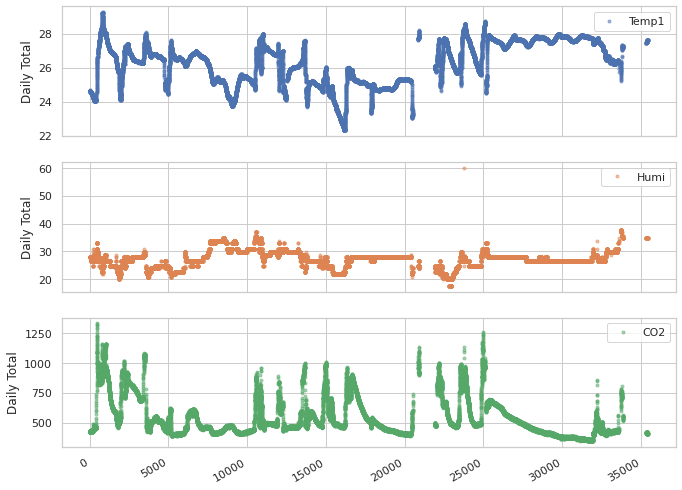

In [18]:
cols_plot = ['Temp1', 'Humi', 'CO2']
axes = data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Total')

### Description of independent attributes
#### Temp1
Range of values observed

In [19]:
print('Range of values:', data['Temp1'].max()-data['Temp1'].min())

Range of values: 6.919999999999998


Central values

In [20]:
print('Minimum temp1:', data['Temp1'].min())
print('Maximum temp1:',data['Temp1'].max())
print('Mean value:', data['Temp1'].mean())
print('Median value:',data['Temp1'].median())
print('Standard deviation:', data['Temp1'].std())

Minimum temp1: 22.32
Maximum temp1: 29.24
Mean value: 26.2837323788893
Median value: 26.48
Standard deviation: 1.2450582743740628


Quartiles

In [21]:
Q1=data['Temp1'].quantile(q=0.25)
Q3=data['Temp1'].quantile(q=0.75)
print('1st Quartile (Q1) is:', Q1)
print('3st Quartile (Q3) is:' , Q3)
print('Interquartile range (IQR) is', Q3-Q1)

1st Quartile (Q1) is: 25.24
3st Quartile (Q3) is: 27.44
Interquartile range (IQR) is 2.200000000000003


Outlier detection from Interquartile range (IQR) in original data

In [22]:
# IQR=Q3-Q1
#lower 1.5*IQR whisker i.e Q1-1.5*IQR
#upper 1.5*IQR whisker i.e Q3+1.5*IQR
L_outliers=Q1-1.5*(Q3-Q1)
U_outliers=Q3+1.5*(Q3-Q1)
print('Lower outliers in temp1:', L_outliers)
print('Upper outliers in temp1:', U_outliers)

Lower outliers in temp1: 21.939999999999994
Upper outliers in temp1: 30.740000000000006


In [23]:
print('Number of outliers in temp1 upper:', data[data['Temp1']>30.74]['Temp1'].count())
print('Number of outliers in temp1 lower:', data[data['Temp1']<21.94]['Temp1'].count())
print('% of Outlier in temp1 upper:',round(data[data['Temp1']>30.74]['Temp1'].count()*100/len(data)), '%')
print('% of Outlier in temp1 lower:',round(data[data['Temp1']<21.94]['Temp1'].count()*100/len(data)), '%')

Number of outliers in temp1 upper: 0
Number of outliers in temp1 lower: 0
% of Outlier in temp1 upper: 0.0 %
% of Outlier in temp1 lower: 0.0 %


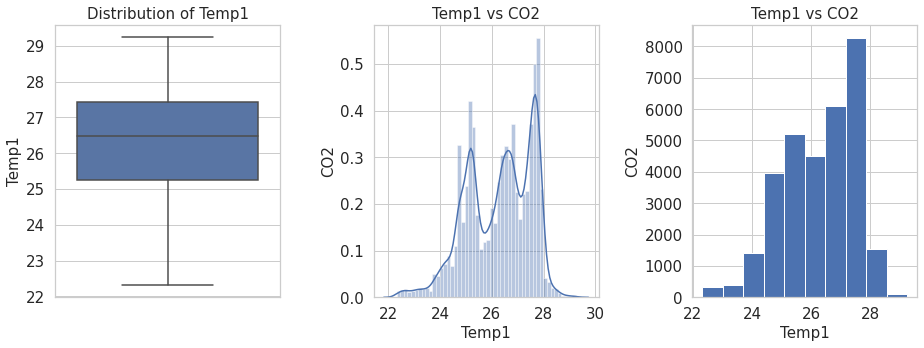

In [24]:
fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(13,5))

#boxplot
sns.boxplot(x='Temp1',data=data,orient='v',ax=ax1)
ax1.set_ylabel('Temp1', fontsize=15)
ax1.set_title('Distribution of Temp1', fontsize=15)
ax1.tick_params(labelsize=15)

#distplot
sns.distplot(data['Temp1'],ax=ax2)
ax2.set_xlabel('Temp1', fontsize=15)
ax2.set_ylabel('CO2', fontsize=15)
ax2.set_title('Temp1 vs CO2', fontsize=15)
ax2.tick_params(labelsize=15)

#histogram
ax3.hist(data['Temp1'])
ax3.set_xlabel('Temp1', fontsize=15)
ax3.set_ylabel('CO2', fontsize=15)
ax3.set_title('Temp1 vs CO2', fontsize=15)
ax3.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

**TEMP2**

Range of values observed

In [25]:
print('Range of values:', data['Temp2'].max()-data['Temp2'].min())

Range of values: 6.600000000000001


Central values

In [26]:
print('Minimum Temp2:', data['Temp2'].min())
print('Maximum Temp2:',data['Temp2'].max())
print('Mean value:', data['Temp2'].mean())
print('Median value:',data['Temp2'].median())
print('Standard deviation:', data['Temp2'].std())
print('Null values:',data['Temp2'].isnull().any())

Minimum Temp2: 20.9
Maximum Temp2: 27.5
Mean value: 25.018312207089608
Median value: 25.2
Standard deviation: 1.1986474646961838
Null values: True


Quartiles

In [27]:
Q1=data['Temp2'].quantile(q=0.25)
Q3=data['Temp2'].quantile(q=0.75)
print('1st Quartile (Q1) is:', Q1)
print('3st Quartile (Q3) is:', Q3)
print('Interquartile range (IQR) is', Q3-Q1)

1st Quartile (Q1) is: 24.1
3st Quartile (Q3) is: 26.1
Interquartile range (IQR) is 2.0


Outlier detection from Interquartile range (IQR) in original data

In [28]:
L_outliers=Q1-1.5*(Q3-Q1)
U_outliers=Q3+1.5*(Q3-Q1)
print('Lower outliers in Temp2:', L_outliers)
print('Upper outliers in Temp2:', U_outliers)

Lower outliers in Temp2: 21.1
Upper outliers in Temp2: 29.1


In [29]:
print('Number of outliers in temp2 upper:', data[data['Temp2']>29.1]['Temp2'].count())
print('Number of outliers in temp2 lower:', data[data['Temp2']<21.1]['Temp2'].count())
print('% of Outlier in temp2 upper:',round(data[data['Temp2']>29.1]['Temp2'].count()*100/len(data)), '%')
print('% of Outlier in temp2 lower:',round(data[data['Temp2']<21.1]['Temp2'].count()*100/len(data)), '%')

Number of outliers in temp2 upper: 0
Number of outliers in temp2 lower: 61
% of Outlier in temp2 upper: 0.0 %
% of Outlier in temp2 lower: 0.0 %


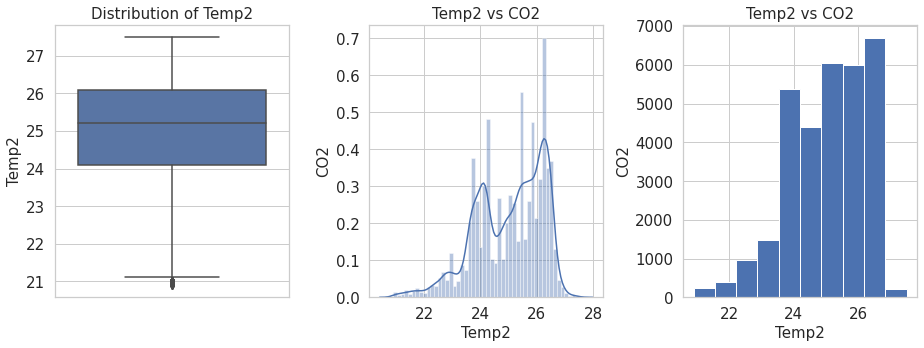

In [30]:
fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(13,5))

#boxplot
sns.boxplot(x='Temp2',data=data,orient='v',ax=ax1)
ax1.set_ylabel('Temp2', fontsize=15)
ax1.set_title('Distribution of Temp2', fontsize=15)
ax1.tick_params(labelsize=15)

#distplot
sns.distplot(data['Temp2'],ax=ax2)
ax2.set_xlabel('Temp2', fontsize=15)
ax2.set_ylabel('CO2', fontsize=15)
ax2.set_title('Temp2 vs CO2', fontsize=15)
ax2.tick_params(labelsize=15)

#histogram
ax3.hist(data['Temp2'])
ax3.set_xlabel('Temp2', fontsize=15)
ax3.set_ylabel('CO2', fontsize=15)
ax3.set_title('Temp2 vs CO2', fontsize=15)
ax3.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

**Humidity**

Range of values observed

In [31]:
print('Range of values:', data['Humi'].max()-data['Humi'].min())

Range of values: 42.35


Central values

In [32]:
print('Minimum Humidity:', data['Humi'].min())
print('Maximum Humidity:',data['Humi'].max())
print('Mean value:', data['Humi'].mean())
print('Median value:',data['Humi'].median())
print('Standard deviation:', data['Humi'].std())
print('Null values:',data['Humi'].isnull().any())

Minimum Humidity: 17.65
Maximum Humidity: 60.0
Mean value: 27.20014082740463
Median value: 26.67
Standard deviation: 2.901517733641322
Null values: True


Quartiles

In [33]:
Q1=data['Humi'].quantile(q=0.25)
Q3=data['Humi'].quantile(q=0.75)
print('1st Quartile (Q1) is:', Q1)
print('3st Quartile (Q3) is:', Q3)
print('Interquartile range (IQR) is', Q3-Q1)

1st Quartile (Q1) is: 26.67
3st Quartile (Q3) is: 27.84
Interquartile range (IQR) is 1.1699999999999982


Outlier detection from Interquartile range (IQR) in original data

In [34]:
L_outliers=Q1-1.5*(Q3-Q1)
U_outliers=Q3+1.5*(Q3-Q1)
print('Lower outliers in Humidity:', L_outliers)
print('Upper outliers in Humidity:', U_outliers)

Lower outliers in Humidity: 24.915000000000006
Upper outliers in Humidity: 29.595


In [35]:
print('Number of outliers in Humidity upper:', data[data['Humi']>29.595]['Humi'].count())
print('Number of outliers in Humidity lower:', data[data['Humi']<24.91]['Humi'].count())
print('% of Outlier in Humidity upper:',round(data[data['Humi']>29.595]['Humi'].count()*100/len(data)), '%')
print('% of Outlier in Humidity lower:',round(data[data['Humi']<24.91]['Humi'].count()*100/len(data)), '%')

Number of outliers in Humidity upper: 6592
Number of outliers in Humidity lower: 7417
% of Outlier in Humidity upper: 19.0 %
% of Outlier in Humidity lower: 21.0 %


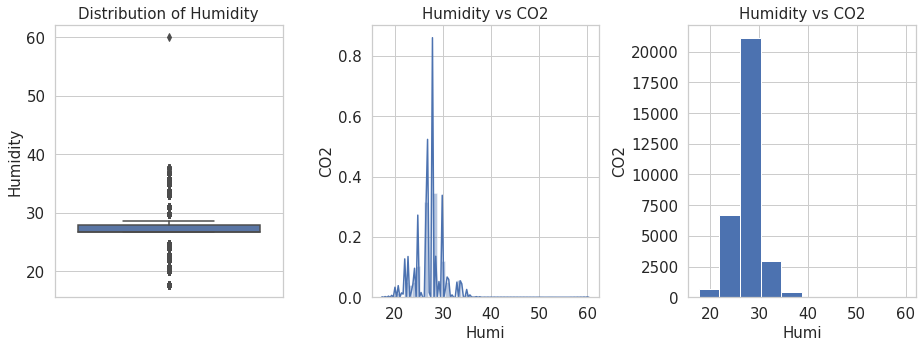

In [36]:
fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(13,5))

#boxplot
sns.boxplot(x='Humi',data=data,orient='v',ax=ax1)
ax1.set_ylabel('Humidity', fontsize=15)
ax1.set_title('Distribution of Humidity', fontsize=15)
ax1.tick_params(labelsize=15)

#distplot
sns.distplot(data['Humi'],ax=ax2)
ax2.set_xlabel('Humi', fontsize=15)
ax2.set_ylabel('CO2', fontsize=15)
ax2.set_title('Humidity vs CO2', fontsize=15)
ax2.tick_params(labelsize=15)

#histogram
ax3.hist(data['Humi'])
ax3.set_xlabel('Humi', fontsize=15)
ax3.set_ylabel('CO2', fontsize=15)
ax3.set_title('Humidity vs CO2', fontsize=15)
ax3.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

>## 3.2 Multivariate analysis

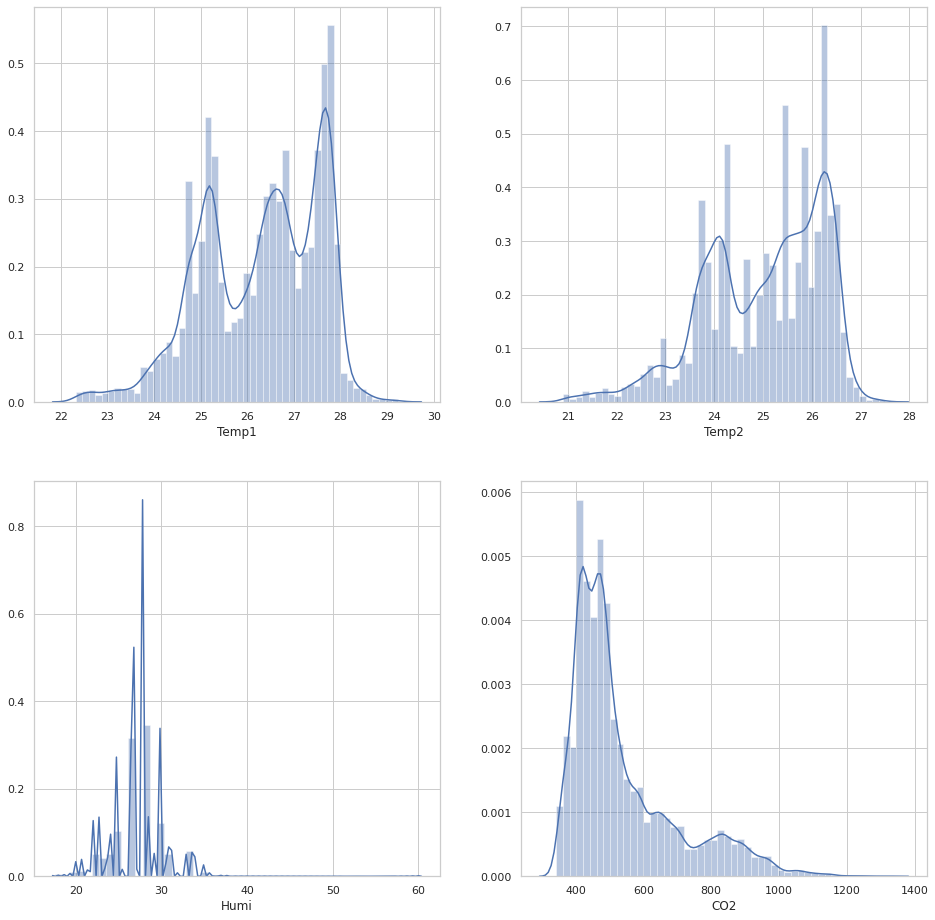

In [37]:
# Distplot
fig, ax2 = plt.subplots(2, 2, figsize=(16, 16))
sns.distplot(data['Temp1'],ax=ax2[0][0])
sns.distplot(data['Temp2'],ax=ax2[0][1])
sns.distplot(data['Humi'],ax=ax2[1][0])
sns.distplot(data['CO2'],ax=ax2[1][1])

We can see observe that :
*   CO2 has almost two gaussians and rightly skewed.
*   Humidity has multiple gaussians.
*   Temp1 has three gaussians.
*   Temp2 has almost two gaussians.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f37b6836358>,
      dtype=object)

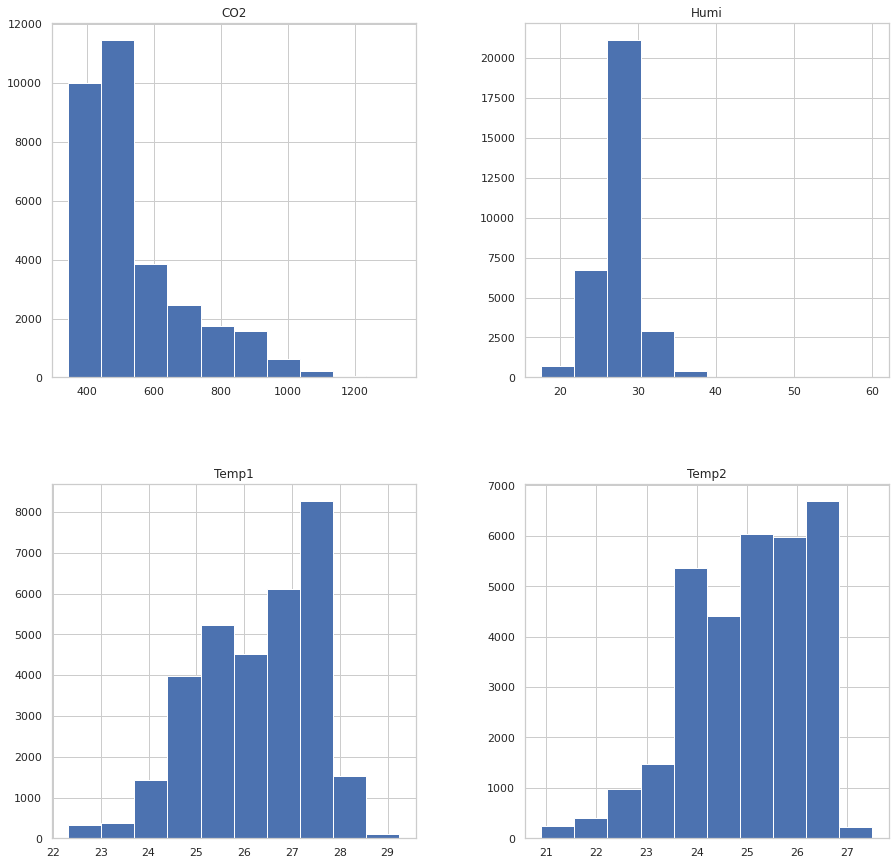

In [38]:
# Histogram 
data.hist(figsize=(15,15))

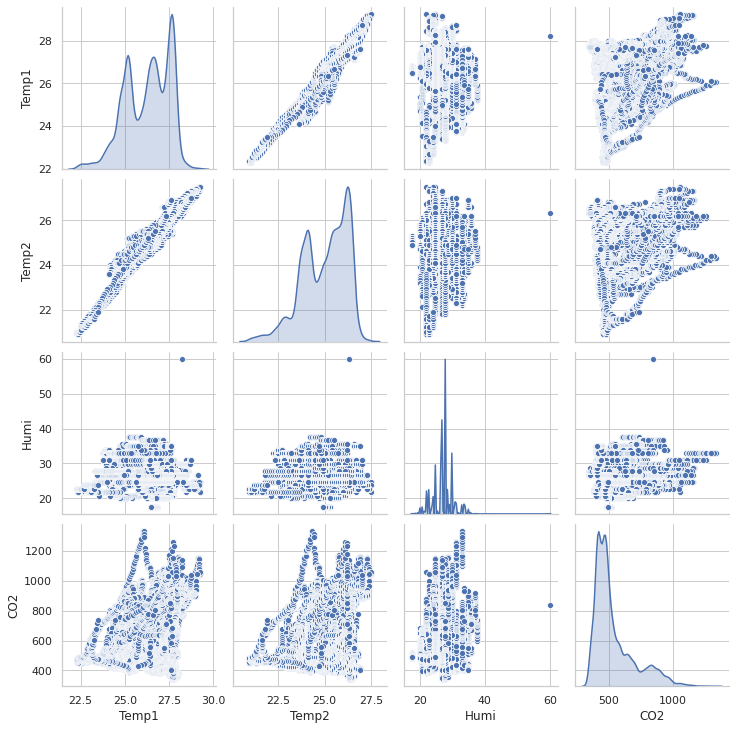

In [39]:
#pairplot- plot density curve instead of histogram in diagonal
sns.pairplot(data, diag_kind='kde')

The diagonal gives the same information, we got using distplot.

*   Temp1 attribute, It do not show presence of outliers.
*   Temp2 attribute, It shows presence of outliers.
*   Humidity attibute, It shows multiple presence of outliers.
*   CO2 attribute, is close to a normal curve 

**We not only have missing values problem but also outliers problem in the dataset.**

**Off Diagonal Analysis: Relationship between indpendent attributes**


**Scatter plots**


*   Temp1 vs. the other attributes: it only shows that can be a high level of correlation with the attribute Temp2, due to both curves are similar.
*   Temp2 vs. other independends attributes: This attribute also does not have any significant relation with any other attributes. It almost spread like a cloud
*   Humidity vs other independs attributes: This attribute also does not have any significant relation with any other attributes. It almost spread like a cloud.

*The reason why we are doing all this analysis is if we find any kind of dimensions which are very strongly correlated (r value close to 1 or -1) such dimensions are giving same information to your algorithms, its a redundant dimension*



In [40]:
# corrlation matrix 
cor=data.corr()
cor

,Temp1,Temp2,Humi,CO2
Temp1,1.000000,0.984957,-0.082079,0.144783
Temp2,0.984957,1.000000,-0.046394,0.125129
Humi,-0.082079,-0.046394,1.000000,-0.013625
CO2,0.144783,0.125129,-0.013625,1.000000


Here, we can see the correlation value between the attributes.

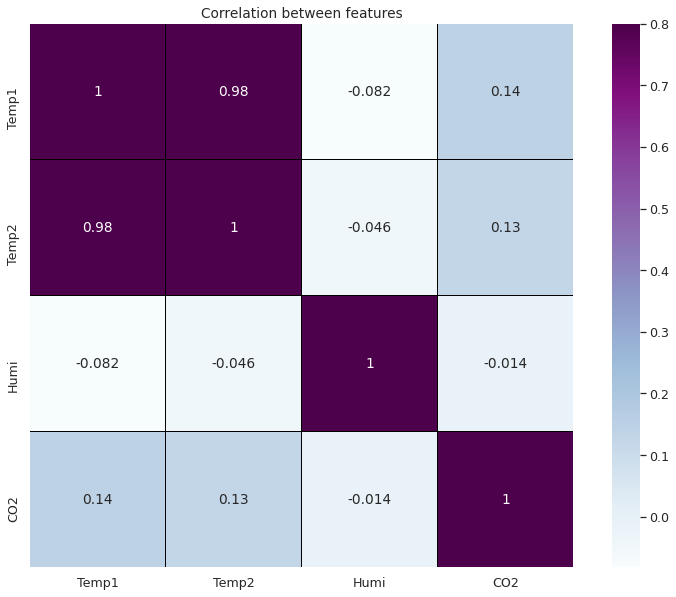

In [41]:
#heatmap
sns.set(font_scale=1.15)
plt.figure(figsize=(14, 10))

sns.heatmap(cor, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap="BuPu",linecolor="black")
plt.title('Correlation between features');

t is also giving the same information we observed in pairplot analysis.
We can see how the correlation between the attributes Temp1 and Temp2 is very high, so it does not provide information, being an attribute which may possibly be eliminated.

> ## 3.3. Strategies to handle different data challenges

#### Checking for Missing Values

In [42]:
#Checking for missing values
del data['Date']
data.isnull().sum()

Temp1    3567
Temp2    3625
Humi     3535
CO2      3433
dtype: int64

We can see that there are missing values.

**Checking for outliers**

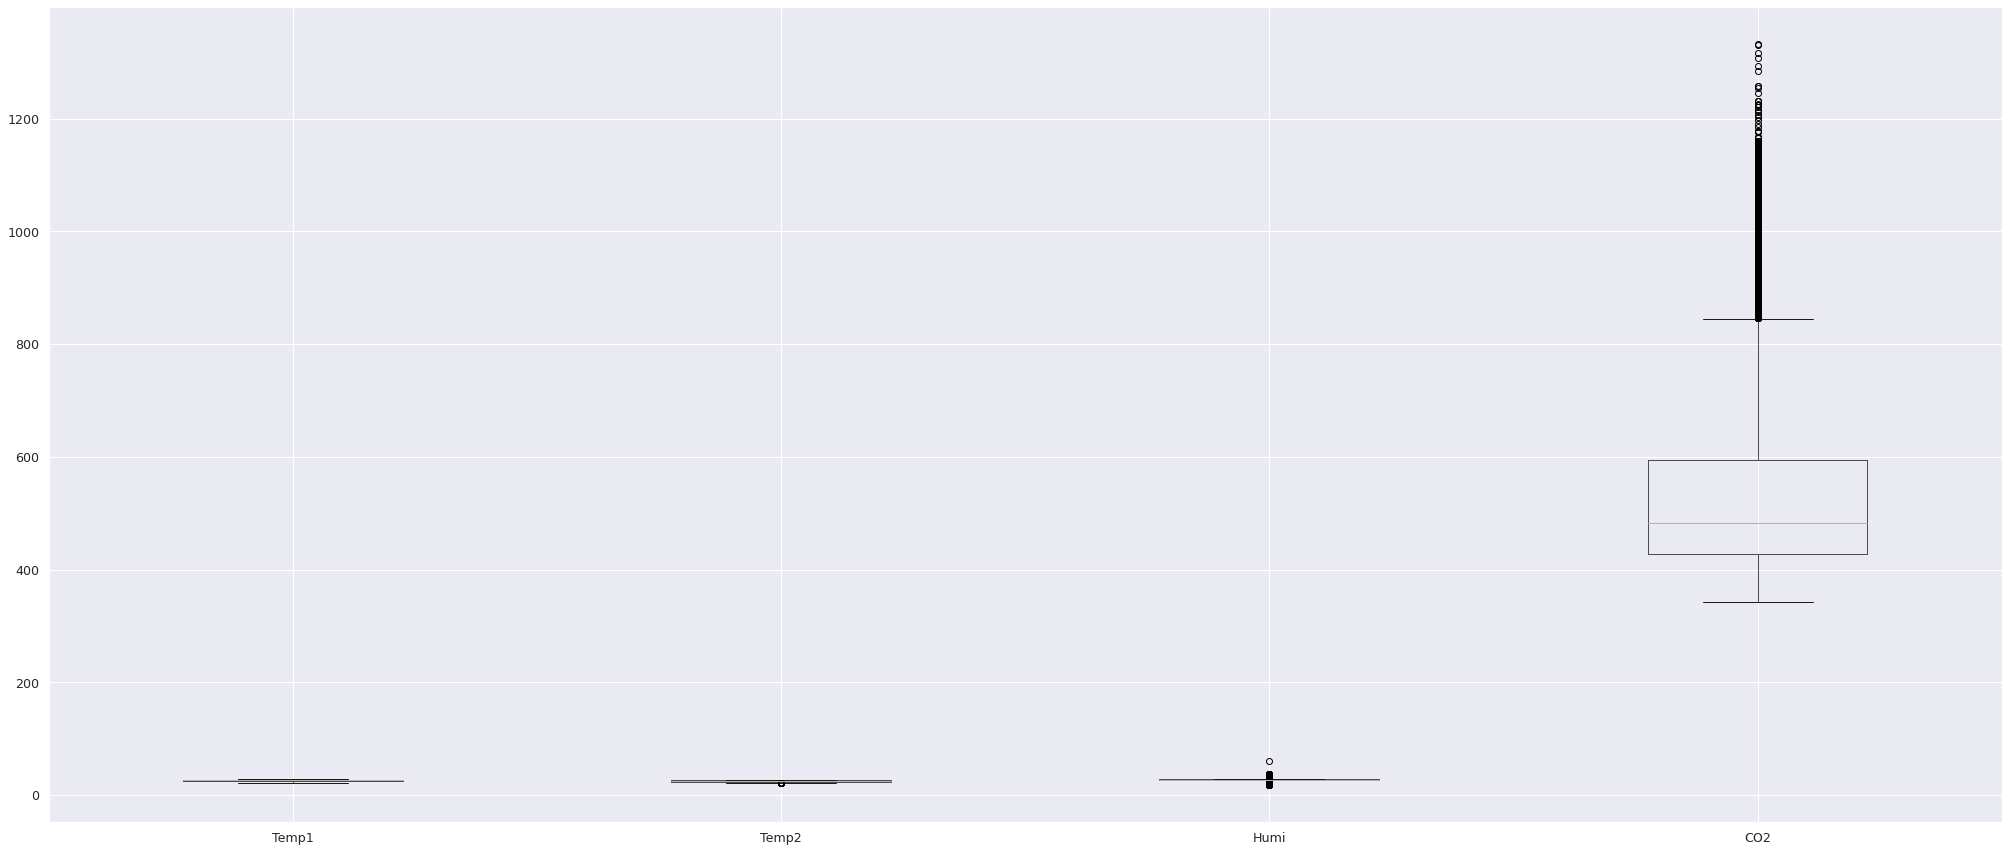

In [43]:
# Creating copy of original dataset
df1=data.copy()
# again check for outliers in dataset after handling missing values using boxplot
df1.boxplot(figsize=(35,15))

It also shows that Humidity, Temp2 and CO2 contains outliers.

In [44]:
#Number of outliers present in the dataset
print('Number of outliers in Temp1:',df1[((df1.Temp1 - df1.Temp1.mean()) / df1.Temp1.std()).abs() >3]['Temp1'].count())
print('Number of outliers in Temp2:',df1[((df1.Temp2 - df1.Temp2.mean()) / df1.Temp2.std()).abs() >3]['Temp2'].count())
print('Number of outliers in Humidity:',df1[((df1.Humi - df1.Humi.mean()) / df1.Humi.std()).abs() >3]['Humi'].count())
print('Number of outliers in CO2:',df1[((df1.CO2 - df1.CO2.mean()) / df1.CO2.std()).abs() >3]['CO2'].count())

Number of outliers in Temp1: 106
Number of outliers in Temp2: 205
Number of outliers in Humidity: 166
Number of outliers in CO2: 328


Here, we have used Standard deviation method to detect the outliers.If we have any data point that is more than 3 times the standard deviation, then those points are very likely to be outliers.
We can see that Temp1, Temp2, Humidity and CO2 contain outliers.

**Handling the outliers**

The alternatives proposed to deal with outliers will be substituting the outlier for the median or eliminating the pattern that has outliers.

In  carrying  out  this  research,  the  elimination  of  those  patterns  with  outliers  has  been chosen, since replacing the median does not make sense, since false information is being generated that has no a priori benefit.

In [0]:
#Replacing the outliers by median
for col_name in df1.columns:
    q1 = df1[col_name].quantile(0.25)
    q3 = df1[col_name].quantile(0.75)
    iqr = q3 - q1
    
    low = q1-1.5*iqr
    high = q3+1.5*iqr
    df1.loc[(df1[col_name] < low) | (df1[col_name] > high), col_name] = df1[col_name].median()

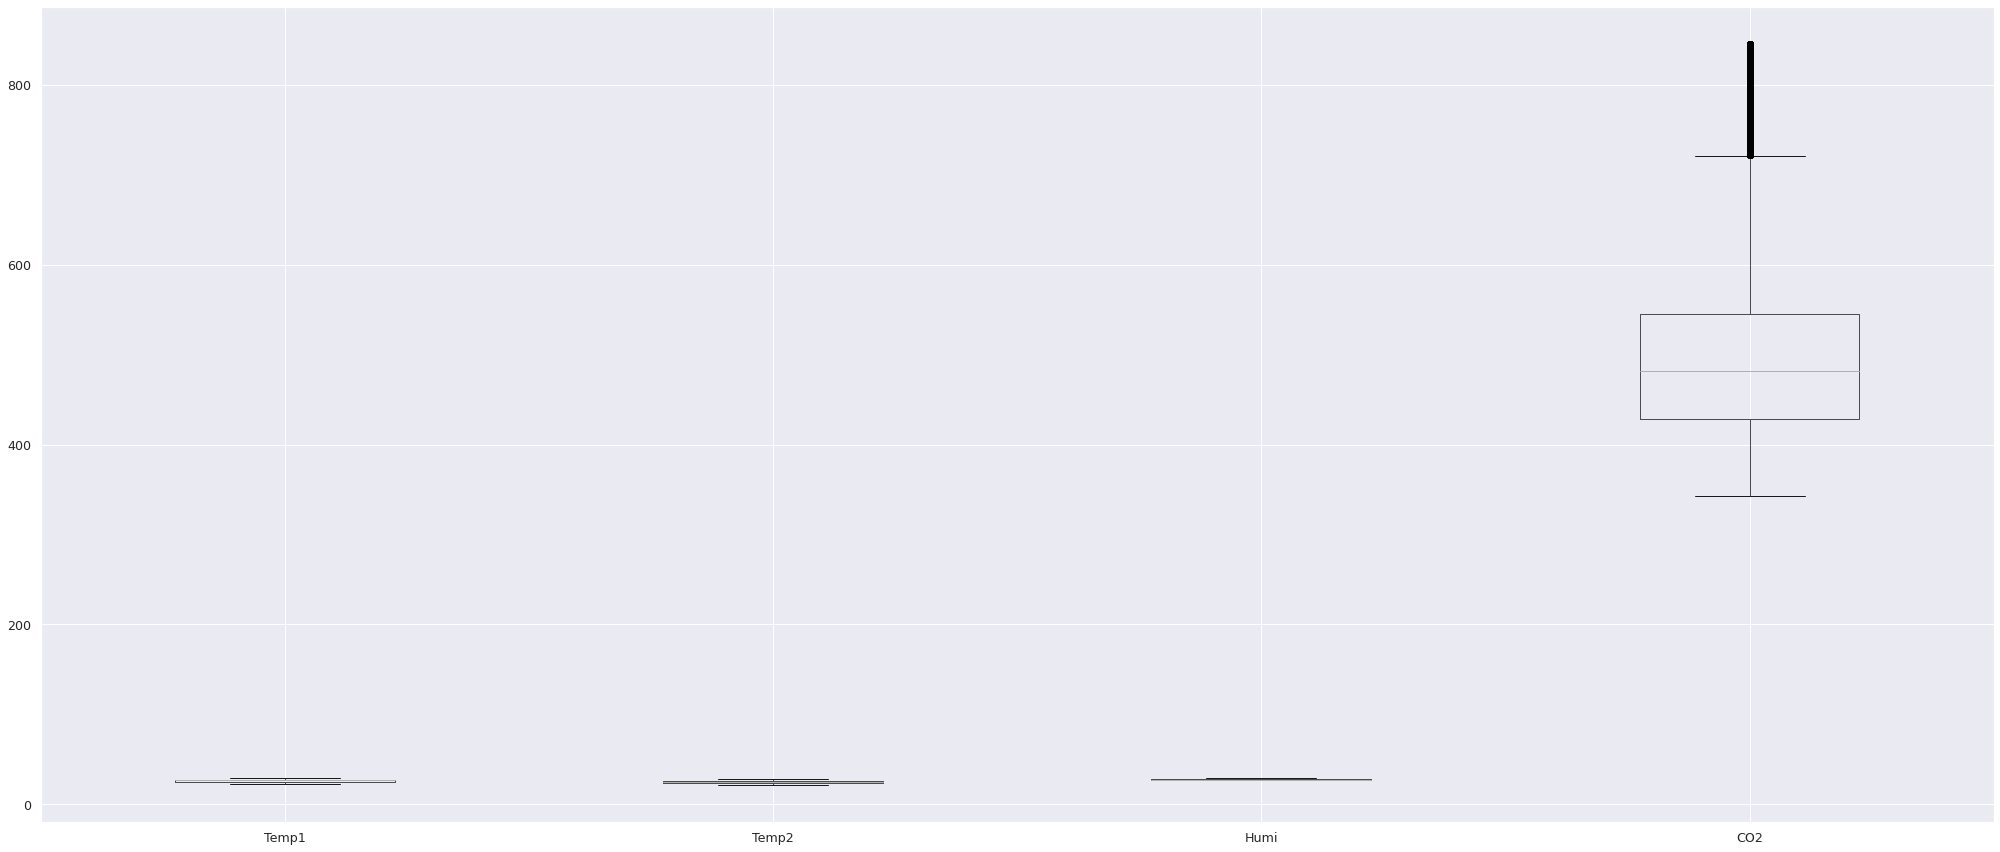

In [46]:
# again check for outliers in dataset using boxplot
df1.boxplot(figsize=(35,15))

#### Preprocessing datasets


In [0]:
def missingDataMean(data, missingData):
    """Replace all missing values of the each column with the mean
    
    Arguments:
        data {[Dataframe]} -- [Dataframe]
        missingData {[List]} -- [Current missing values]  
    """    
    numPatterns = data.shape[0]
    # Remove attributes with >= 80% missing values
    for index, value in enumerate(missingData):
        if value/numPatterns >= 0.8:
            data.drop([list(data.columns[:-1])[index]], axis=1, inplace=True)    
    # Replace missing values by mean
    data.fillna(data.mean(), inplace=True)
def normalizeDataset(df):
    """Normalize the current dataset between max and min values of each column
    Arguments:
        data {[df]} -- [Dataframe]
    """   
    df = (df - df.min()) / (df.max() - df.min())
    return df
def interpolateData(df):
    """Replace all missing values of the each column with interpolation method
    
    Arguments:
        df {[Dataframe]} -- [Dataframe]
    """   
    for (columnName, columnData) in data.iteritems():
        columnData.interpolate(method='linear', inplace=True)
    return df    
def delete_outliers(df1):
    # Outliers detection and remove
    data = df1.copy()
    for i in data.columns:
            data_dict = data[((data[i] - data[i].mean()) / data[i].std()).abs() >3][i].to_dict()
            for key in data_dict:
                data = data.drop(key)
    return data

In [0]:
# Loop all files in current directory
for file in os.listdir("file_output"):
  # Only these files with .csv extension
    if fnmatch.fnmatch(file, '*.csv'):
        # Read each file
        data = pd.read_csv("file_output/"+file, na_values = missing_values, sep=",")
        # Delete date attribute
        del data['Date']
        # Create correlation matrix
        corr_matrix = data.corr().abs()
        # Select upper triangle of correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        # Find index of feature columns with correlation greater than 0.95
        to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]        
        # Drop features with high correlation
        data = data.drop(data[to_drop], axis=1)
        # Remove outliers
        data = delete_outliers(data)
        # Missing values detection
        missingData = list(data.isnull().sum())
        # If missing values is missing = replace by mean or interpolation
        if data.isnull().values.any():
            #missingDataMean(data, missingData)
            interpolateData(data)    
        data = normalizeDataset(data)
        data = data.drop_duplicates(keep="first", inplace=False)    
        # Delete all empty rows
        data = data.dropna(axis=0, how='all', thresh=None, subset=None, inplace=False)         # Re-insert Date attr and put in first attr position
        data.to_csv("Preprocesed_"+file, index=False, header=True, decimal=".", sep=",", float_format='%.5f')
        Path("Preprocesed_"+file).rename("./dataset/final/Preprocesed_"+file)

Preprocesed output files features:

*   All attributes is in the same scale between 0 and 1.
*   Outliers have been deleted.
*   Missing Values have been replaced by mean / interpolation.
*   Correlated attributes have been deleted.
*   Duplicate values have been removed


#### Output Dataset Visualization

In [49]:
# Use april preprocesed file to display info
data = pd.read_csv("dataset/final/Preprocesed_april_output.csv", sep=",")
# Display the new dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21951 entries, 0 to 21950
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Temp1   21951 non-null  float64
 1   Humi    21951 non-null  float64
 2   CO2     21951 non-null  float64
dtypes: float64(3)
memory usage: 514.6 KB


In [50]:
#Check top few records of the dataset
data.head()

,Temp1,Humi,CO2
0,0.32407,0.49968,0.12314
1,0.32099,0.49968,0.12314
2,0.32407,0.49968,0.11979
3,0.32099,0.49968,0.11835
4,0.32099,0.49968,0.11548


In [51]:
#Analyze the distribution of the dataset
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Temp1,21951.0,0.580786,0.189000,0.0,0.41975,0.61728,0.73910,1.0
Humi,21951.0,0.480988,0.229522,0.0,0.30019,0.42511,0.62460,1.0
CO2,21951.0,0.347538,0.246636,0.0,0.16483,0.25122,0.49689,1.0


In [52]:
# corrlation matrix 
cor=data.corr()
cor

,Temp1,Humi,CO2
Temp1,1.000000,0.077816,0.195028
Humi,0.077816,1.000000,-0.152465
CO2,0.195028,-0.152465,1.000000


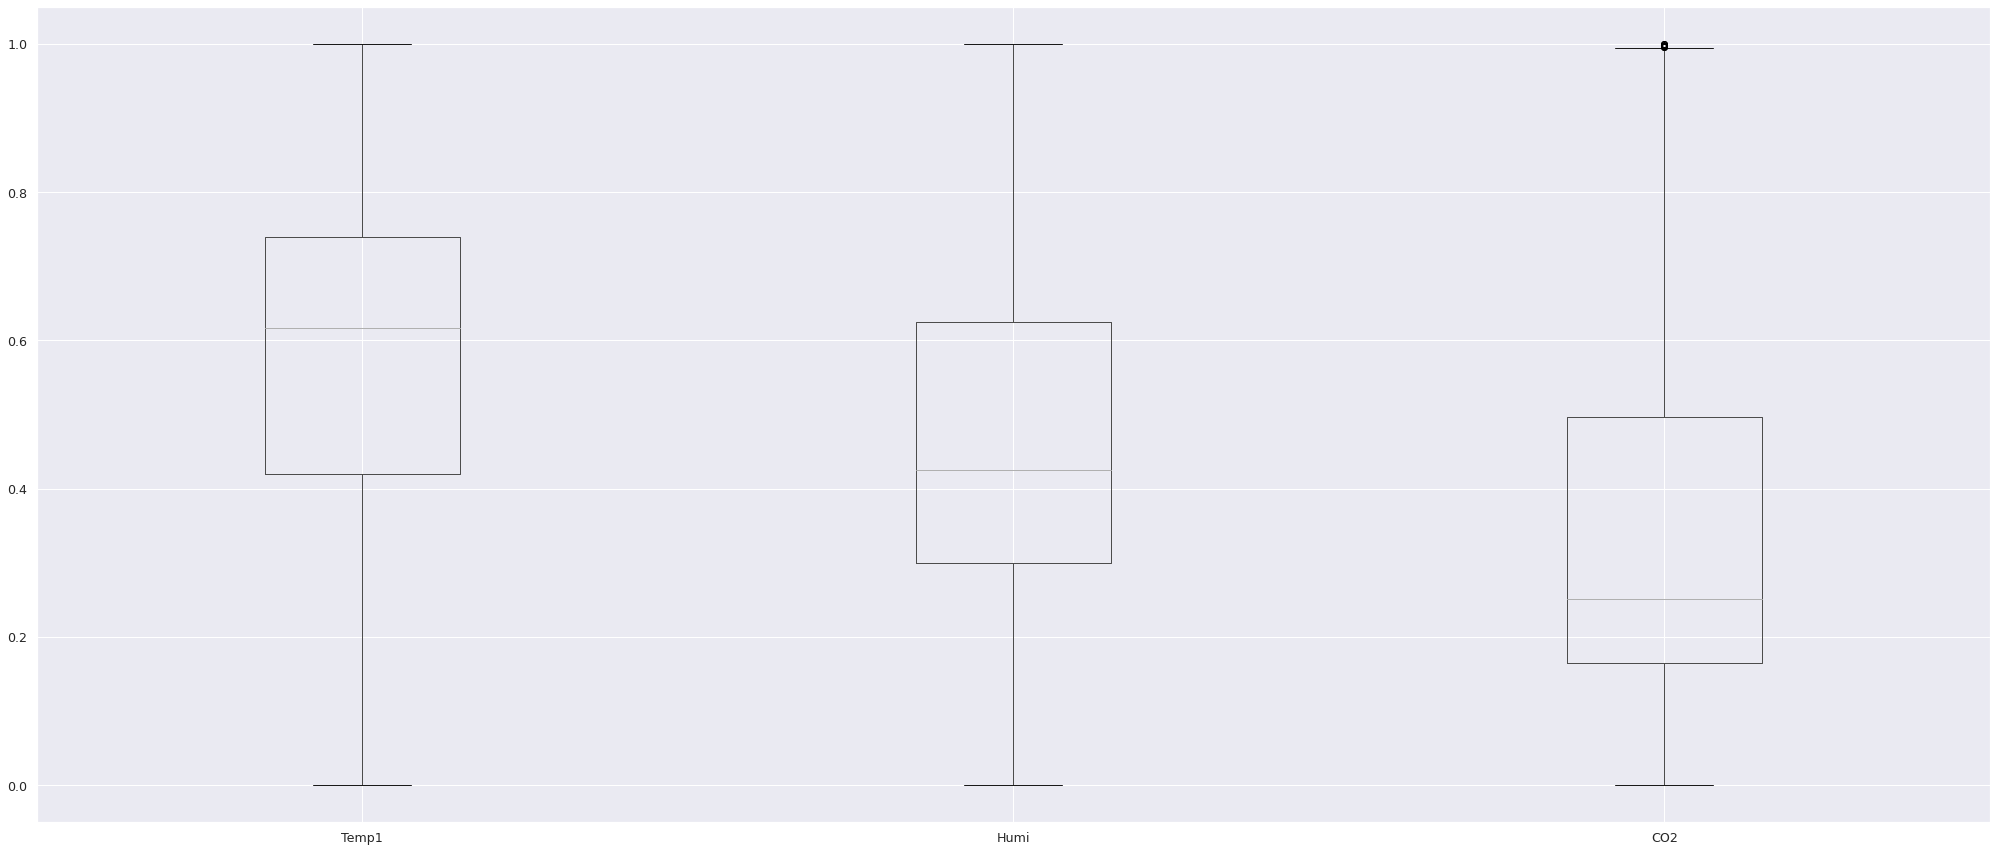

In [53]:
# again check for outliers in dataset using boxplot
data.boxplot(figsize=(35,15))

# Algorithms Comparison

In [0]:
def GetBasedModel():
    models = []
    models.append(('LN', linear_model.LinearRegression())) #(Regression - Supervised)
    models.append(('RID', Ridge())) #(Regression - Supervised)
    models.append(('LSO', Lasso())) #(Regression - Supervised)
    models.append(('EN',  ElasticNet())) #(Regression - Supervised)  
    models.append(('SVR', SVR())) #(Regression - Supervised)    
    return models

In [0]:
class PlotBoxR(object):
    def __Trace(self,nameOfFeature,value): 
        trace = go.Box(
            y=value,
            name = nameOfFeature,
            marker = dict(
                color = 'rgb(0, 128, 128)',
            )
        )
        return trace

    def PlotResult(self,names,results):      
        data = []
        for i in range(len(names)):
            data.append(self.__Trace(names[i],results[i]))
        py.iplot(data)

In [0]:
def ScoreDataFrame(names,results):
    def floatingDecimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}"     
        return float(prc.format(f_val))
    scores = []
    for r in results:
        scores.append(floatingDecimals(r.mean(),4))
    scoreDataFrame = pd.DataFrame({'Model':names, 'Score': scores})
    return scoreDataFrame

In [0]:
def GetScaledModel(nameOfScaler):
    
    if nameOfScaler == 'standard':
        scaler = StandardScaler()
    elif nameOfScaler =='minmax':
        scaler = MinMaxScaler()
    elif nameOfScaler == 'Robust':
        scaler= RobustScaler()
    elif nameOfScaler == 'normalizer':
        scaler= Normalizer()
        
    pipelines = []
    pipelines.append((nameOfScaler+'LN'  , Pipeline([('Scaler', scaler),('LN',  linear_model.LinearRegression())])))
    pipelines.append((nameOfScaler+'RID'  , Pipeline([('Scaler', scaler),('RID',  Ridge())])))
    pipelines.append((nameOfScaler+'LSO'  , Pipeline([('Scaler', scaler),('LSO',  Lasso())])))
    pipelines.append((nameOfScaler+'EN'  , Pipeline([('Scaler', scaler),('EN',  ElasticNet())])))
    pipelines.append((nameOfScaler+'SVR'  , Pipeline([('Scaler', scaler),('SVR',  SVR())])))
    return pipelines 

In [0]:
df  = pd.read_csv('dataset/final/Preprocesed_april_output.csv', sep=",")

In [0]:
X = df.iloc[:,:-1] # X is all attributes whitout CO2
Y = df.iloc[:,-1] # Y is CO2 column
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=22)

In [60]:
X_train.shape, X_test.shape , y_train.shape, y_test.shape

((17560, 2), (4391, 2), (17560,), (4391,))

In [0]:
 def BasedLine2(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 5
    scoring = 'r2'
    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=num_folds, random_state=42)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

Name   MSE   STD
LN: 0.065278 (0.007120)
RID: 0.065278 (0.007102)
LSO: -0.000986 (0.001263)
EN: -0.000986 (0.001263)
SVR: 0.328932 (0.002269)


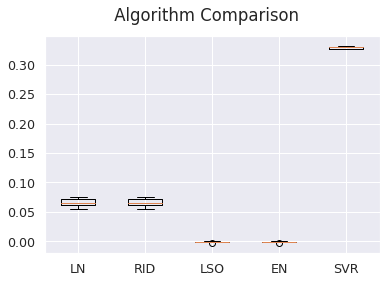

In [62]:
models = GetBasedModel()
print("Name   MSE   STD")
names,results = BasedLine2(X_train, y_train,models)
fig = pyplot.figure()
fig.suptitle( ' Algorithm Comparison ' )
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [63]:
basedLineScore = ScoreDataFrame(names,results)
basedLineScore.sort_values(by='Score', ascending=False)

,Model,Score
4,SVR,0.3289
0,LN,0.0653
1,RID,0.0653
2,LSO,-0.0010
3,EN,-0.0010


In [64]:
models = GetScaledModel('standard')
names,results = BasedLine2(X_train, y_train,models)

scaledScoreStandard = ScoreDataFrame(names,results)
compareModels = pd.concat([basedLineScore,
                           scaledScoreStandard], axis=1)
compareModels

standardLN: 0.065278 (0.007120)
standardRID: 0.065278 (0.007120)
standardLSO: -0.000986 (0.001263)
standardEN: -0.000986 (0.001263)
standardSVR: 0.328387 (0.002815)


,Model,Score,Model,Score
0,LN,0.0653,standardLN,0.0653
1,RID,0.0653,standardRID,0.0653
2,LSO,-0.0010,standardLSO,-0.0010
3,EN,-0.0010,standardEN,-0.0010
4,SVR,0.3289,standardSVR,0.3284


In [65]:
models = GetScaledModel('minmax')
names,results = BasedLine2(X_train, y_train,models)

scaledScoreMinMax = ScoreDataFrame(names,results)
compareModels = pd.concat([basedLineScore,
                           scaledScoreStandard,
                          scaledScoreMinMax], axis=1)
compareModels

minmaxLN: 0.065278 (0.007120)
minmaxRID: 0.065278 (0.007103)
minmaxLSO: -0.000986 (0.001263)
minmaxEN: -0.000986 (0.001263)
minmaxSVR: 0.328785 (0.002264)


,Model,Score,Model,Score,Model,Score
0,LN,0.0653,standardLN,0.0653,minmaxLN,0.0653
1,RID,0.0653,standardRID,0.0653,minmaxRID,0.0653
2,LSO,-0.0010,standardLSO,-0.0010,minmaxLSO,-0.0010
3,EN,-0.0010,standardEN,-0.0010,minmaxEN,-0.0010
4,SVR,0.3289,standardSVR,0.3284,minmaxSVR,0.3288


In [66]:
models = GetScaledModel('normalizer')
names,results = BasedLine2(X_train, y_train,models)

scaledScoreNormal = ScoreDataFrame(names,results)
compareModels = pd.concat([basedLineScore,
                           scaledScoreStandard,
                          scaledScoreMinMax,scaledScoreNormal], axis=1)
compareModels

normalizerLN: 0.068296 (0.006353)
normalizerRID: 0.068282 (0.006226)
normalizerLSO: -0.000986 (0.001263)
normalizerEN: -0.000986 (0.001263)
normalizerSVR: 0.115913 (0.010438)


,Model,Score,Model,Score,Model,Score,Model,Score
0,LN,0.0653,standardLN,0.0653,minmaxLN,0.0653,normalizerLN,0.0683
1,RID,0.0653,standardRID,0.0653,minmaxRID,0.0653,normalizerRID,0.0683
2,LSO,-0.0010,standardLSO,-0.0010,minmaxLSO,-0.0010,normalizerLSO,-0.0010
3,EN,-0.0010,standardEN,-0.0010,minmaxEN,-0.0010,normalizerEN,-0.0010
4,SVR,0.3289,standardSVR,0.3284,minmaxSVR,0.3288,normalizerSVR,0.1159


In [67]:
models = GetScaledModel('Robust')
names,results = BasedLine2(X_train, y_train,models)

scaledScoreRobust = ScoreDataFrame(names,results)
compareModels = pd.concat([basedLineScore,
                           scaledScoreStandard,
                          scaledScoreMinMax,scaledScoreNormal,scaledScoreRobust], axis=1)
compareModels

RobustLN: 0.065278 (0.007120)
RobustRID: 0.065278 (0.007119)
RobustLSO: -0.000986 (0.001263)
RobustEN: -0.000986 (0.001263)
RobustSVR: 0.329006 (0.002133)


,Model,Score,Model,Score,Model,Score,Model,Score,Model,Score
0,LN,0.0653,standardLN,0.0653,minmaxLN,0.0653,normalizerLN,0.0683,RobustLN,0.0653
1,RID,0.0653,standardRID,0.0653,minmaxRID,0.0653,normalizerRID,0.0683,RobustRID,0.0653
2,LSO,-0.0010,standardLSO,-0.0010,minmaxLSO,-0.0010,normalizerLSO,-0.0010,RobustLSO,-0.0010
3,EN,-0.0010,standardEN,-0.0010,minmaxEN,-0.0010,normalizerEN,-0.0010,RobustEN,-0.0010
4,SVR,0.3289,standardSVR,0.3284,minmaxSVR,0.3288,normalizerSVR,0.1159,RobustSVR,0.3290


# SVR Parameters Optimization

Nested cross-validation is used to estimate generalization performance of a full learning pipeline, which includes optimizing hyperparameters. We will use five folds in the outer loop.

## **Parameters to optimice**
**C (Regularisation)**: C is the penalty parameter. The higher the Penalty value the model makes fewer mistakes but it is observed that after a certain Penalty value the model is over training.

**Gamma**: It defines how far influences the calculation of plausible line of separation. The higher the gamma value, only near points are considered.
A lower gamma value, far away points are also considered.

**epsilon**: It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.

## Optimizing Parameters


## How to optimize the parameters

**Score:** Return the coefficient of determination R^2 of the prediction.

The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares.

The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

In [0]:
def MSE(y_true,y_pred):
    mse = mean_squared_error(y_true, y_pred)
    print ('MSE: %2.3f' % mse)
    return mse

def R2(y_true,y_pred):    
     r2 = r2_score(y_true, y_pred)
     print ('R2: %2.3f' % r2)
     return r2

def two_score(y_true,y_pred):    
    MSE(y_true,y_pred) #set score here and not below if using MSE in GridCV
    score = R2(y_true,y_pred)
    return score

def two_scorer():
  return make_scorer(two_score, greater_is_better=True) # change for false if using MSE

In [0]:
class RandomSearch(object):    
    def __init__(self,X_train,y_train,model,hyperparameters):        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        self.best_score = []
        self.best_params = []        
    def RandomSearch(self):
        # Create randomized search 53-fold cross validation and 20 iterations
        cv = 3
        clf = RandomizedSearchCV(self.model,
                                 self.hyperparameters,
                                 random_state=1,
                                 n_iter=20,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 scoring=two_scorer(),
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        self.best_score.append(best_model.best_score_)
        self.best_params.append(best_model.best_params_)
        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):        
        best_model,_ = self.RandomSearch()
        pred = best_model.predict(X_test)
        return pred

class GridSearch(object):    
    def __init__(self,X_train,y_train,model,hyperparameters):        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        self.best_score = []
        self.best_params = []
        
    def GridSearch(self):
        # Create randomized search 3-fold cross validation
        cv = 3
        clf = GridSearchCV(self.model,
                                 self.hyperparameters,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 refit=True,
                                 error_score=0,
                                 scoring=two_scorer(),
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        self.best_score.append(best_model.best_score_)
        self.best_params.append(best_model.best_params_)                 
        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        best_model,_ = self.GridSearch()
        pred = best_model.predict(X_test)
        return pred        

In [0]:
# Range of parameters to optimize
kernel = ['rbf']
gamma = np.logspace(-15, 3, num=9, base=2)
tol = [0.0001, 0.001, 0.1, 1]
C = np.logspace(-5, 15, num=11, base=2)
epsilon = [0.0001, 0.001, 0.1, 1]

# Create hyperparameter dictionary
hyperparameters= dict(
  kernel = kernel,
  gamma = gamma,
  tol = tol,
  C = C,
  epsilon = epsilon
)
# The model will be SVR
model = SVR()

### Search best parameters with the whole dataset preprocesed

In [71]:
data  = pd.read_csv('dataset/final/Preprocesed_april_output.csv', sep=",")
# X is all attributes whitout CO2
X = data.iloc[:,:-1]
# Y is CO2 column
Y = data.iloc[:,-1] 
# Split the dataset in 4 part two train and two test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=22)
# Get the current size of each part
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# Start timer
start = time.time()  
# Use StandarScaler to scale features
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
rescaledValidationX = scaler.transform(X_test)
# Apply RandomSearch or GridSearch to find parameters of SVR
gs = RandomSearch(rescaledX, y_train, model, hyperparameters)
Prediction = gs.BestModelPridict(rescaledValidationX)
# End timer and 
end = time.time() 
temp = end-start   
hours = temp//3600
temp = temp - 3600*hours
minutes = temp//60
seconds = temp - 60*minutes
print('%d:%d:%d' %(hours,minutes,seconds),'R2 Score:', gs.best_score, gs.best_params)

(17560, 2) (4391, 2) (17560,) (4391,)


KeyboardInterrupt: ignored

### Fit the current model


In [72]:
data  = pd.read_csv('dataset/final/Preprocesed_april_output.csv', sep=",")
# X is all attributes whitout CO2
X = data.iloc[:,:-1] 
# Y is CO2 column
Y = data.iloc[:,-1] 
# Split the dataset in 4 part two train and two test with 20% patterns for test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=22)
# Use StandarScaler to scale features
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
# Create SVR Model with the best features obtained
model = SVR(
        tol=0.0001,
        kernel='rbf',
        gamma=8.0,
        epsilon=0.1,
        C=512,  
)
# Fit the model with rescaled train and y_train
model.fit(rescaledX, y_train)
# Estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model.predict(rescaledValidationX)
# Return the R2 score
model.score(rescaledX, y_train)

0.53811278071326

In [73]:
# Score for validation dataset
model.score(rescaledValidationX, y_test)

0.5329433206767276

### Dataset divided in train - test files, preprocessed individually


In [0]:
data  = pd.read_csv('file_output/april_output.csv', na_values = missing_values, sep=",")
# Extract 75% data to train dataset
train_pct_index = int(0.75 * len(data))
# Extract the other 25% of data to test dataset
X_train, X_test = data[:train_pct_index], data[train_pct_index:]
X_train.to_csv("train_april.csv", index=False, header=True, decimal=".", sep=",", float_format='%.2f')
X_test.to_csv("test_april.csv", index=False, header=True, decimal=".", sep=",", float_format='%.2f')

In [0]:
# Loop all files in current directory
for file in os.listdir("."):
  # Only these files with .csv extension
    if fnmatch.fnmatch(file, '*_april.csv'):
        # Read each file
        data = pd.read_csv(file, na_values = missing_values, sep=",")
        # Delete date attribute
        del data['Date']
        # Create correlation matrix
        corr_matrix = data.corr().abs()
        # Select upper triangle of correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        # Find index of feature columns with correlation greater than 0.95
        to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]        
        # Drop features with high correlation
        data = data.drop(data[to_drop], axis=1)
        # Remove outliers
        data = delete_outliers(data)
        # Missing values detection
        missingData = list(data.isnull().sum())
        # If missing values is missing = replace by mean or interpolation
        if data.isnull().values.any():
            #missingDataMean(data, missingData)
            interpolateData(data)    
        data = normalizeDataset(data)
        data = data.drop_duplicates(keep="first", inplace=False)   
        # Drop all rows that it is completly empty
        data = data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
        # Re-insert Date attr and put in first attr position
        data.to_csv(file, index=False, header=True, decimal=".", sep=",", float_format='%.5f')

In [77]:
# Read the train and test files
train  = pd.read_csv('train_april.csv', sep=",")
test  = pd.read_csv('test_april.csv', sep=",")


X_train = train.iloc[:,:-1] # X_train is all attributes whitout CO2 of train dataset
y_train = train.iloc[:,-1] # Y_train is CO2 column of train dataset
X_test = test.iloc[:,:-1] # X_test is all attributes whitout CO2 of test dataset
y_test = test.iloc[:,-1]  # Y_test is CO2 column of test dataset

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

start = time.time()
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
rescaledValidationX = scaler.transform(X_test)
# Using RandomSearch or GridSearch to find the best parameters
gs = RandomSearch(X_train,y_train,model,hyperparameters)
Prediction = gs.BestModelPridict(rescaledValidationX)

end = time.time() 
temp = end-start   
hours = temp//3600
temp = temp - 3600*hours
minutes = temp//60
seconds = temp - 60*minutes

print('%d:%d:%d' %(hours,minutes,seconds),'R2 Score:', gs.best_score, gs.best_params)

(17380, 2) (4700, 2) (17380,) (4700,)


KeyboardInterrupt: ignored

### Fit the new model


In [78]:
'''train  = pd.read_csv('dataset/final/Preprocesed_april_output.csv', sep=",")
test  = pd.read_csv('dataset/final/Preprocesed_march_output.csv', sep=",")'''
train  = pd.read_csv('train_april.csv', sep=",")
test  = pd.read_csv('test_april.csv', sep=",")
X_train = train.iloc[:,:-1] # X_train is all attributes whitout CO2 of train dataset
y_train = train.iloc[:,-1] # Y_train is CO2 column of train dataset
X_test = test.iloc[:,:-1] # X_test is all attributes whitout CO2 of test dataset
y_test = test.iloc[:,-1]  # Y_test is CO2 column of test dataset

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

model = SVR(
        tol=0.0001,
        kernel='rbf',
        gamma=8.0,
        epsilon=0.1,
        C=512, 
)
model.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model.predict(rescaledValidationX)
model.score(rescaledX, y_train)

0.643074750982638

In [79]:
model.score(rescaledValidationX, y_test)

-1.0526230424608025